Tools

In [1]:
import sys  
sys.path.append('/home/josorior/kinetick/source')

In [16]:
# Standard tool packages
import jax
jax.config.update("jax_enable_x64", True)
from jax import grad, jacfwd, hessian
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxopt import LBFGS
# My tools
from models import *
from mykernels import get_gaussianRBF
# Settings
#plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (5, 5)

## PDE

The Poisson equation in 2d is given by
$$
\begin{align*}

\partial_t \rho (x) &= g(x) & \text{for } x \in \Omega = (-3,3)^2 \\
\rho(x) &= 0, & \text{for } x \in \partial\Omega
\end{align*}
$$
whose analytical solution is known to be
$$
\rho(x) = \text{write me please}
$$

We will use the kernel method in closed form since the PDE operator is linear.


## Kernel solution

Choose a kernel

In [3]:
k = get_gaussianRBF(0.2)

First we choose collocation pointsets $\Omega^*\subset\Omega$ and $\Omega^*\subset\partial\Omega$

In [4]:
# \Omega
M_int = int(jnp.sqrt(500))
x_1 = jnp.linspace(-3,3,M_int)[1:]
x_2 = x_1
X_1, X_2 = jnp.meshgrid(x_1, x_2)
pairs_int = jnp.vstack([X_1.ravel(),X_2.ravel()]).T
M_int = pairs_int.shape[0]
# \partial\Omega
M_bdry = int(25*4)
bottom = jnp.vstack((jnp.linspace(-3,3,M_bdry//4), jnp.tile(-3,M_bdry//4))).T
top = jnp.vstack((jnp.linspace(-3,3,M_bdry//4), jnp.tile(3,M_bdry//4))).T
left = jnp.vstack((jnp.tile(-3,M_bdry//4),jnp.linspace(-3,3,M_bdry//4))).T[1:-1]
right = jnp.vstack((jnp.tile(3,M_bdry//4),jnp.linspace(-3,3,M_bdry//4))).T[1:-1]
pairs_bdry = jnp.vstack((left,bottom,right,top))
M_bdry = pairs_bdry.shape[0]

Build the kernel matrix $K(\phi,\phi)$ where $\phi = [\phi_\Omega, \phi_{\partial\Omega}]$ and
$$
\phi_\Omega \left(\square\right) = \delta_{x}\circ \Delta \left(\square\right) \qquad \text{for } x\in \Omega
$$
$$
\phi_{\partial\Omega} \left(\square\right) = \delta_x\left(\square\right) \qquad \text{for } x\in \partial \Omega
$$
Thus, the matrix has the form
$$
K(\phi,\phi) = 
\begin{pmatrix}
\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right) \\
\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) & \phi_{\partial\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right) \\
\end{pmatrix}
$$
where for instance the block $\phi_{\Omega}\left(\phi_{\partial\Omega}\left(K(x,y)\right)\right)$ is evaluated as:

1. Apply $\phi_{\partial\Omega}$ to the function $K(x,y)$ as a function of $x$ only. 

2. Apply $\phi_\Omega$ to $\phi_{\partial\Omega}\left(K(x,y)\right)$ as a function of $y$ only.

Let's compute the blocks.

$$\phi_{\Omega}\left(\phi_{\Omega}\left(K(x,y)\right)\right)$$

In [42]:
def vectorize_kfunc(k):
    return jax.vmap(jax.vmap(k, in_axes=(None,0)), in_axes=(0,None))

def op_k_apply(k,L_op,R_op):
    return R_op(L_op(k,0),1)

def make_block(k,L_op,R_op):
    return vectorize_kfunc(op_k_apply(k,L_op,R_op))

# Define f
def f(x):
    return 100*(jnp.sum(x**2))

vec_f = vmap(f)

# Operators
def laplacian_k(k,index):
    def lapk(*args):
        return jnp.trace(jax.hessian(k,index)(*args))
    return lapk

def eval_k(k,index):
    return k

In [6]:
b11 = make_block(k,laplacian_k,laplacian_k)(pairs_int,pairs_int)
b21 = make_block(k,laplacian_k,eval_k)(pairs_bdry,pairs_int)
b12 = b21.T
b22 = make_block(k,eval_k,eval_k)(pairs_bdry,pairs_bdry)

k_pp = jnp.block([[b11,b12],
                [b21,b22]])

In [11]:
# loss function
n1 = 1e-6
n2 = 1e-6
f_vals = jnp.block([f(pairs_int),jnp.zeros(M_bdry)])
B = jnp.block([[jnp.zeros((M_int,M_int)), jnp.zeros((M_int,M_bdry))],
              [jnp.zeros((M_bdry,M_int)), jnp.eye(M_bdry)]])
A = jnp.block([[jnp.eye(M_int), jnp.zeros((M_int,M_bdry))],
              [jnp.zeros((M_bdry,M_int)), jnp.zeros((M_bdry,M_bdry))]])
def loss(z):
    return z.T @ jnp.linalg.solve(k_pp,z) + 1/(M_int*n1)*jnp.sum((A@z - f_vals)**2) + 1/(M_bdry*n2)*jnp.sum((B @ z)**2)

In [17]:
z0 = jax.random.uniform(key = jax.random.PRNGKey(1), shape=(M_int+M_bdry,), minval=0, maxval=1)
solver = LBFGS(fun=loss, maxiter=100)
res = solver.run(z0)

In [20]:
z_star = res.params

In [57]:
beta = jnp.linalg.solve(k_pp,z_star)
def rho_star(x):
    b1 = make_block(k,eval_k,laplacian_k)(x,pairs_int)[0,:]
    b2 = make_block(k,eval_k,eval_k)(x,pairs_bdry)[0,:]
    return jnp.concatenate([b1,b2]) @ beta

In [92]:
t = vmap(laplacian_k(k,1),in_axes=(None,1))
t(jnp.array([1.,2.]), pairs_int).shape

TypeError: sub got incompatible shapes for broadcasting: (2,), (441,).

In [63]:
pred = rho_star(pairs_int)

In [66]:
pred.shape

()

ValueError: z array must have same length as triangulation x and y arrays

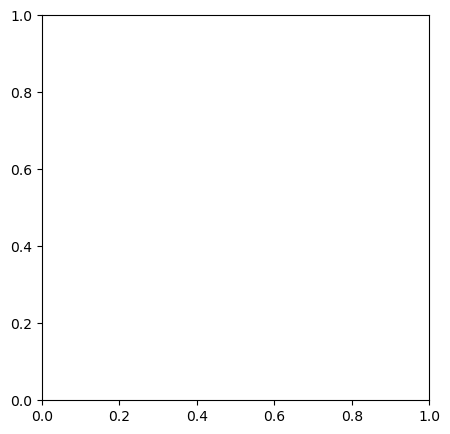

In [65]:
plt.tricontourf(pairs_int[:,0],pairs_int[:,1],pred)